In [1]:
import pandas as pd
import numpy as np
import easygui
import scipy.optimize
import re
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter, FuncFormatter

import trmc.kin as kin
import trmc.load as load
import trmc.analysis as analysis
import os


import matplotlib as mpl
from matplotlib import animation, rc
from IPython.display import HTML


mpl.rc('font',**{'size' : 16})

class exp_formatter(): 
    """used to format exponentials of ticks"""
    def __init__(self,exponent):
        self.exponent = exponent
    
    def format_func(self,value, tick_number):
        return ("{:0=1.0f}").format(value/10**self.exponent)
#         return ("{:0=1.0f}e" + str(self.exponent)).format(value/10**self.exponent)

In [2]:
basedir = '/home/lee/OneDrive/Data/TRMC/Refined/Freqdep/'

fps = {
    'KCs' :  basedir + 'KCs/',
    'PC' :  basedir + 'PC/',
    'SP' :  basedir + 'SP/'
}

# os.listdir(fps['SP'])

In [18]:
def fit_lor(sweep, p0, bounds = ([0,0,0, 0],[np.inf,np.inf,np.inf,np.inf]), window = 105):
    
    xdata = sweep.index.values
    ydata = sweep.values
    
    minidx = ydata.argmin()
    minfreq = xdata[minidx]
    
    sl = slice(minidx-window,minidx+window)
    popt,popc = scipy.optimize.curve_fit(analysis.lor,xdata[sl],ydata[sl], p0 , bounds = bounds)

    return popt, sl

def fit_poly(sweep, window = 105, order = 3):
    
    xdata = sweep.index.values
    ydata = sweep.values
    
    minidx = ydata.argmin()
    minfreq = xdata[minidx]
    
    bounds = ([0,0,0],[np.inf,np.inf,np.inf])
    
    sl = slice(minidx-window,minidx+window+1)
    p = np.polyfit(xdata[sl],ydata[sl], order)
    fit_func = np.poly1d(p)
    
    return fit_func, p, sl


def polymin(v0,v0_sl, fit):
    f = np.linspace(v0.index[v0_sl][0],v0.index[v0_sl][-1],num = 1000)
    fitdata = fit(f)
    minR = fitdata.min()
    minf = f[fitdata.argmin()]
    return minR, minf

/home/lee/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


(8420000000.0, 8652000000.0)

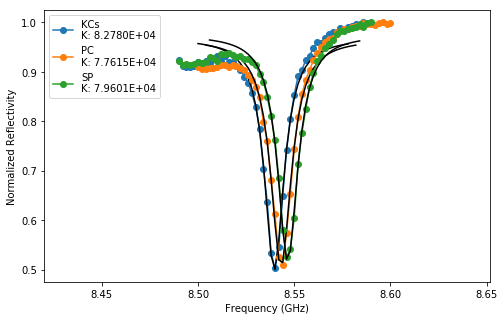

In [4]:
fps_sw = {}

fps_sw['KCs'] = fps['KCs'] + "Sweep_0ms_exp.csv"
fps_sw['PC'] = fps['PC'] + "Sweep_0ms_exp.csv"
fps_sw['SP'] = fps['SP'] + "Sweep_0ms_exp.csv"

# fps_sw['KCs_0ms_after'] = defaultpath + "Sample KCs/Sweep_0ms_afterZ_exp.csv"

swps = []
swps_V = []
maxV = {}

for samp in fps_sw:  
    if samp == 'KCs':
        df = pd.read_csv(fps_sw[samp],index_col=False)
        df = df.set_index(df['f(Ghz)'])
        swps.append(df['Experimental R'])
        swps_V.append(df[' Vsignal(V)'])
        maxV[samp] = df[' Vsignal(V)'].max()
    
    else:
        df = pd.read_csv(fps_sw[samp], index_col = 0, skiprows = 4)
        swps.append(df['Reflectivity'])
        maxV[samp] = 0.12
    
    
swps = dict(zip(fps_sw.keys(),swps))
swps_V = dict(zip(fps_sw.keys(),swps_V))

back_V_fit = {} #Forgot to copy values sometimes, so using the Vsignal max value and R0 to estimate background voltage
K = {}

fig, ax = plt.subplots(1,figsize = (8,5))
for sample in swps:
    sweep = swps[sample]
    
    p0 =[sweep.argmin(),1e7,.5 ,1]
    popt, sl = fit_lor(sweep, p0, window = 20)
    fit_func = analysis.lor(sweep.index.values,*popt)

#     fit_func, popt, sl = fit_poly(sweep, window = 3)

    K[sample] = analysis.calc_K(f0 = popt[0], w = popt[1], R0 = popt[2], printparams = False)
    back_V_fit[sample] = -maxV[sample]*popt[2]
    
    ax.plot(sweep, marker = 'o', label = (sample + "\nK: " + str("{:0.4E}".format(K[sample]))))
    ax.plot(sweep.index.values[sl],fit_func[sl] , color = 'black')
    ax.set_xlabel('Frequency (GHz)')
    ax.set_ylabel('Normalized Reflectivity')
ax.legend()
ax.xaxis.get_offset_text().set_visible(False)
ax.set_xlim(8.42e9,8.652e9)

In [5]:
ffpath = os.path.join(fps['KCs'],'FreqFluence')
folders = os.listdir(ffpath)
miarray = []
folder_re = '^(\d+\.\d+)GHz_(.+?)'
file_re = 'FF_Filter=\d+_Fluence=(.+?)_data.csv'

flist = []

for folder in folders:
    m_folder = re.search(folder_re,folder)
    freq = float(m_folder.groups(0)[0])*1e9
    direction = m_folder.groups(0)[1]
    folderpath = os.path.join(ffpath,folder)
    files = os.listdir(folderpath)
    for file in files:
        if file[0] == 'F':
            m_file = re.search(file_re, file)
            fluence = float(m_file.groups(0)[0])
            
            fp = os.path.join(folderpath,file)
            
            miarray.append((direction,freq,fluence))
            flist.append(fp)

In [6]:
mi = pd.MultiIndex.from_tuples(miarray)

time_arr = load.load_trace(flist[0]).index.values
miarray_t = []
for tup in mi:
    for time in time_arr:
        miarray_t.append((*tup,time))
        
mi_t = pd.MultiIndex.from_tuples(miarray_t, names = ['Direction','Frequency','Fluence','Time'])

s_files = pd.Series(flist, index = mi)


In [7]:

direcs = set(s_files.index.levels[0])
freqs = set(s_files.index.levels[1])
fluences = set(s_files.index.levels[2])


data = np.zeros([len(direcs)*len(freqs)*len(fluences),len(time_arr)])


lowpow = mi.levels[2].min()

backvs = []
re_backV = "^Background Voltage,-(\d+\.\d+)(.)V"
re_backV2 = "^Background Voltage,-(\d+)(.)V"

lp = 0

for i, tup in enumerate(mi):
    direc, freq, fluence = tup
    fp = s_files[direc,freq,fluence]
    if(fluence == lowpow):
        lp = load.load_trace(fp,50e-9).values
        data[i,:] = lp - lp
    else:
        d = load.load_trace(fp,50e-9).values
        
        data[i,:] = d - lp
        
    with open(fp) as p:
        for i, line in enumerate(p):
            if i == 11:
                m = re.search(re_backV,line)
                if m == None:
                    m = re.search(re_backV2,line)
                
                if m.groups()[1] == 'm':
                    fac = 1e-3
                elif m.groups()[1] == 'µ':
                    fac = 1e-6
                    
                
                backvs.append(float(m.groups()[0])*fac)
            
data = data.flatten()

s = pd.Series(data,index = mi_t)

backvs = pd.Series(backvs,index = mi).xs(mi.levels[2][-1],level =2)

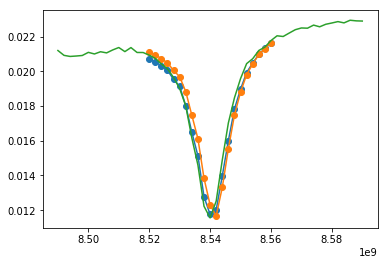

In [8]:
plt.plot(backvs.xs('U').sort_index(level = 1),marker = 'o')
plt.plot(backvs.xs('D').sort_index(level = 1),marker = 'o')
plt.plot(swps_V['KCs'])

(2e-07, 7e-07)

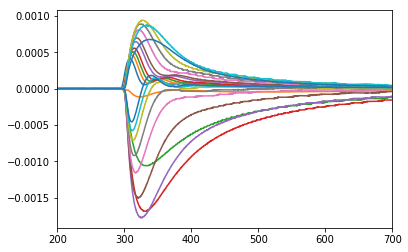

In [9]:
s1 = s.xs('U',level = 0).sort_index(level = 0)
fluences = s1.index.levels[1]
s2 = s1.xs(fluences.max(),level = 1).sort_index(level = 0)

s2 = s2.swaplevel(0,1).sort_index()


fig, ax = plt.subplots()

freqs = s2.index.levels[1]
for freq in freqs:
    ax.plot(s2[:,freq])
    
ax.xaxis.set_major_formatter(FuncFormatter(exp_formatter(-9).format_func))
ax.set_xlim([200e-9,700e-9])

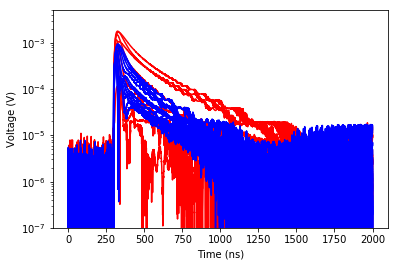

In [10]:
fig, ax = plt.subplots()

for freq in s2.index.levels[1]:
    trace = s2[:,freq]
    if len(trace.shape) == 1:
        if np.trapz(trace) > 0:
            color = 'b'
            zorder = 2
        else:
            color = 'r'
            zorder = 1
        ax.plot(abs(trace), color = color, zorder = zorder )
        

ax.set_yscale('log')
ax.set_ylim([1e-7,5e-3])
ax.set_ylabel('Voltage (V)')
ax.set_xlabel('Time (ns)')

expf = exp_formatter(-9)
ax.xaxis.set_major_formatter(FuncFormatter(expf.format_func))

(2.5e-07, 7e-07)

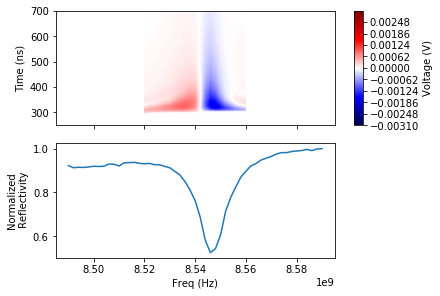

In [11]:
x = s2.index.levels[1]
y = s2.index.levels[0]
z = s2.values.reshape(len(s2.index.levels[0]),len(s2.index.levels[1]))

levels = list(np.arange(-3.1e-3,3.1e-3,1e-5))

xi, yi = np.meshgrid(x,y)

fig , axes = plt.subplots(2,1 , sharex = True,constrained_layout=True)

cs = axes[0].contourf(xi,yi,z, levels, cmap='seismic')
cb = fig.colorbar(cs, ax = axes[0])


expf = exp_formatter(-9)
axes[0].yaxis.set_major_formatter(FuncFormatter(expf.format_func))
axes[0].set_ylabel('Time (ns)')
axes[1].set_xlabel('Freq (Hz)')
axes[1].set_ylabel('Normalized\n Reflectivity')
cb.set_label('Voltage (V)')

axes[1].plot(sweep)

axes[0].set_ylim([2.5e-7,0.7e-6])
# axes[0].set_xlim([8.535e9,8.545e9])

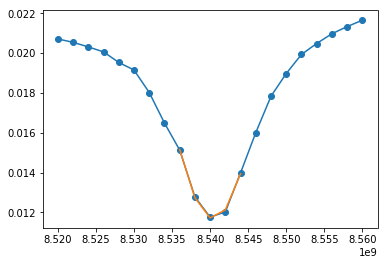

In [19]:
# params = np.zeros([len(s2_red.index.levels[0]),len(p_labels)])

v0 = backvs.xs('U').sort_index(level = 1)

s2_red = s2.loc[::10,:]
s2_red.index = s2_red.index.remove_unused_levels()


fits = s2_red.copy()
vss = s2_red.copy()
dvs = s2_red.copy()


# fittype = 'lor'
fittype = 'poly'

window = 3

if fittype == 'lor':

    Rinf = 0.02125
    p0 =[v0.idxmin(),1e7,0.01, Rinf]
    epsilon = 0.00001
    window = 10

    p_labels = ['f0','Q','R','Rinf']
    
    v0_p, v0_sl = fit_lor(v0, p0,bounds = ([0,0,0, Rinf - epsilon],[np.inf,np.inf,np.inf, Rinf + epsilon]), window = window)
    v0_fit = analysis.lor(v0.index, *v0_p)
    v0_fit = pd.Series( v0_fit,v0.index)
    
elif fittype == 'poly':
    v0_fit, v0_p, v0_sl = fit_poly(v0, window = 2, order = 2)

    minR, minf = polymin(v0, v0_sl, v0_fit)
    v0_p = [minR, minf]
    p_labels = ['R', 'f0']

params = pd.DataFrame(index = s2_red.index.levels[0], columns = p_labels)

v0_p = pd.Series(v0_p,index = p_labels)

plt.plot(v0,marker = 'o')
plt.plot(v0.index[v0_sl], v0_fit(v0.index[v0_sl]))


In [20]:
for i, time in enumerate(s2_red.index.levels[0]):
    dv = s2_red.loc[time]
    dvs.loc[time, :] =dv.values
    
    vs = v0 + dv
    vss.loc[time, :] =vs.values
    
    if fittype == 'lor':
        vs_p, vs_sl = fit_lor(vs, p0,bounds = ([0,0,0, Rinf - epsilon],[np.inf,np.inf,np.inf, Rinf + epsilon]), window = window)
        vs_fit = analysis.lor(vs.index, *vs_p)
    elif fittype == 'poly':
        vs_fit, vs_p, vs_sl = fit_poly(vs, window = 2, order = 2)

        minR, minf = polymin(vs, vs_sl, vs_fit)
        vs_p = [minR, minf]
        
        vs_fit = vs_fit(vs.index)
        
    fits.loc[time, :] =vs_fit
    
    params.loc[time] = vs_p

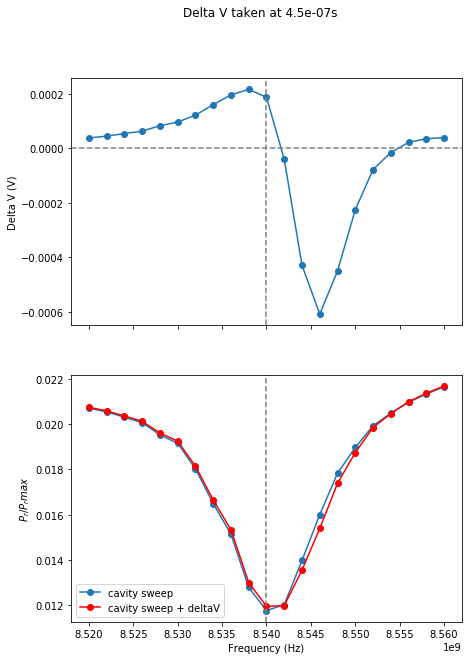

In [14]:
fittimes = fits.index.levels[0]
timesel = 450e-9
timesel = min(fittimes, key=lambda x:abs(x-timesel))

fig, axes = plt.subplots(2,1, figsize = (7,10), sharex = True)

axes[0].plot(dvs[timesel], marker = 'o')

axes[1].plot(v0, label = 'cavity sweep', marker = 'o')
# axes[1].plot(v0_fit, label = 'cavity sweep fit')

axes[1].plot(vss[timesel], color = 'r', label = 'cavity sweep + deltaV' ,  marker = 'o')
# axes[1].plot(fits.loc[timesel], label = 'cavity sweep + deltaV fit')

axes[1].axvline(v0.idxmin(), color = 'gray', linestyle = '--')
axes[0].axvline(v0.idxmin(), color = 'gray', linestyle = '--')
axes[0].axhline(0, color = 'gray', linestyle = '--')

axes[0].set_ylabel('Delta V (V)')
axes[1].set_ylabel('$P_r/P_rmax$')
axes[1].set_xlabel('Frequency (Hz)')

# axes[1].set_xlim([8.525e9,8.545e9])
# axes[1].set_ylim([0.4,0.8])

fig.suptitle('Delta V taken at ' + str(timesel) + 's')

plt.legend()

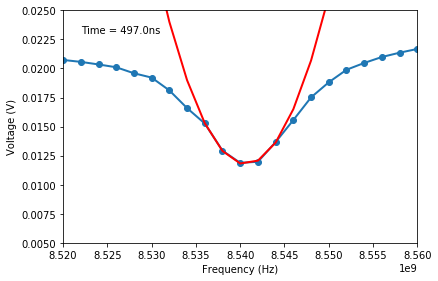

In [21]:
# First set up the figure, the axis, and the plot element we want to animate

timesel1 = 250e-9
timesel2 = 500e-9

fittimes = fits.index.levels[0]

idx1 = abs(fittimes - timesel1).argmin()
idx2 = abs(fittimes - timesel2).argmin()

RawData_Frames = vss.loc[fittimes[idx1]:fittimes[idx2], :]
RawData_Frames_fit = fits.loc[fittimes[idx1]:fittimes[idx2], :]
timeindex = fittimes[idx1:idx2]
interval = 50
xs = fits.index.levels[1]

fig = plt.figure()
ax = plt.axes(xlim=(xs[0], xs[-1]), ylim = (0.005,0.025))

line, = ax.plot([], [], lw=2, marker = 'o')
line_fit, = ax.plot([], [], lw=2, color = 'r')

time_template = 'Time = %.1fns'
time_text = ax.text(0.05, 0.9, '', transform=ax.transAxes)

fig.tight_layout()

# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    line_fit.set_data([], [])
    time_text.set_text('')
    ax.set_ylabel("Voltage (V)")
    ax.set_xlabel("Frequency (Hz)") 
    return line,line_fit

# animation function.  This is called sequentially
def animate(i):
    line.set_data(xs, RawData_Frames.loc[timeindex[i]])
    line_fit.set_data(xs, RawData_Frames_fit.loc[timeindex[i]])
    time_text.set_text(time_template % int(timeindex[i]*1e9))
    return line, time_text



# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=len(timeindex), interval = interval, blit=True)


# TML(anim.to_html5_video())

# equivalent to rcParams['animation.html'] = 'html5'
rc('animation', html='html5')

anim

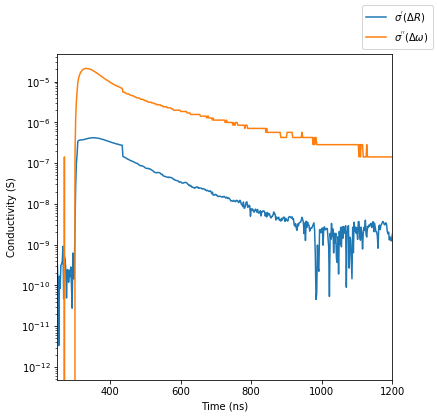

In [22]:
fig, axes = plt.subplots(1,1, figsize = (6,6), sharex = True)

e0 = 8.854e-12
F=1


deltaR = params['R']- v0_p['R']
sig_R = (1/K['KCs'])*(deltaR/v0_p['R'])

deltaf = params['f0']- v0_p['f0']
deltaf = abs(deltaf)
    

sig_R = abs(sig_R)
sig_I = 2*deltaf*e0/F
    
axes.plot(sig_R, label = '$\sigma^{\'}(\Delta R)$')
axes.set_yscale('log')
axes.set_ylabel('Conductivity (S)')

axes.plot(sig_I, label = '$\sigma^{\'\'}(\Delta\omega)$')
axes.set_yscale('log')
axes.set_ylabel('Conductivity (S)')

axes.set_xlim(250e-9,1200e-9)

fmt = exp_formatter(-9)
axes.xaxis.set_major_formatter(FuncFormatter(fmt.format_func))
axes.set_xlabel('Time (ns)')
# for ax in axes:
# axes.set_ylim([1e-8,1e-4])
fig.legend()